<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W4/ungraded_labs/C3_W4_Lab_2_irish_lyrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Generating Text from Irish Lyrics

In the previous lab, you trained a model on just a single song. You might have found that the output text can quickly become gibberish or repetitive. Even if you tweak the hyperparameters, the model will still be limited by its vocabulary of only 263 words. The model will be more flexible if you train it on a much larger corpus and that's what you'll be doing in this lab. You will use lyrics from more Irish songs then see how the generated text looks like. You will also see how this impacts the process from data preparation to model training. Let's get started!

In [1]:
# Install this package to use Colab's GPU for training
# !apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

## Imports

In [49]:
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Building the Word Vocabulary

You will first download the lyrics dataset. These will be from a compilation of traditional Irish songs and you can see them [here](https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C3/W4/misc/Laurences_generated_poetry.txt). 

In [2]:
# Download the dataset
!wget -P data/ https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt

--2022-11-01 15:46:40--  https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.122.128, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘data/irish-lyrics-eof.txt’

irish-lyrics-eof.tx 100%[===================>]  67.35K  --.-KB/s    in 0.08s   

2022-11-01 15:46:40 (808 KB/s) - ‘data/irish-lyrics-eof.txt’ saved [68970/68970]



Next, you will lowercase and split the plain text into a list of sentences:

In [62]:
# Load the dataset
data = open("./data/irish-lyrics-eof.txt").read()

# Lowercase and split the text
# corpus = data.lower().split("\n")

seinfeld_scripts = pd.read_csv('data/seinfeld_scripts.csv')
corpus = seinfeld_scripts[seinfeld_scripts['character'] == 'JERRY'].sample(n=5000)['dialogue'].tolist()

# Preview the result
print(corpus[0:100])

['Just go back and ask him again.', "I wouldn't know where to start.", 'Here we go.', "Ya, that's the.. last thing you want to see. Well, next to last.", "Me neither. I love the previews. In fact I enjoy being in the theatre cut up. Last week after a preview, I yelled out 'Must miss'.", "Uh, excuse me. I know this is gonna sound crazy but I - I have to have that rye. It's a - it's a long story, but a person's whole future may depend on it.", "That's perfect.", 'Oh, that was a strike! Did you see that?!', "Great. You know, Frankie, I was wondering. What if I decided that it's silly to drive a van, because, you know, I live in New York City. Is there maybe some way I could exchange it?", "You know, I tell ya, I gotta say that I'm enjoying adulthood. For a lot of reasons. And, I'll tell you reason number one as an adult, if I want a cookie, I have a cookie, okay? I have three cookies or four cookies, or eleven cookies if I want. Many times I will intentionally ruin my entire appetite. Jus

From here, you can initialize the `Tokenizer` class and generate the word index dictionary:

In [63]:
# Initialize the Tokenizer class
tokenizer = Tokenizer()

# Generate the word index dictionary
tokenizer.fit_on_texts(corpus)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

pp.pprint(f"word index dictionary: {list(tokenizer.word_index.items())[0:50]}")
print(f"total words: {total_words}")

("word index dictionary: [('you', 1), ('i', 2), ('the', 3), ('a', 4), ('to', "
 "5), ('it', 6), ('what', 7), ('that', 8), ('of', 9), ('and', 10), ('is', 11), "
 '(\'in\', 12), (\'this\', 13), (\'know\', 14), ("i\'m", 15), (\'no\', 16), '
 '("don\'t", 17), (\'oh\', 18), (\'yeah\', 19), (\'me\', 20), (\'on\', 21), '
 '("it\'s", 22), (\'well\', 23), (\'do\', 24), (\'so\', 25), (\'my\', 26), '
 "('have', 27), ('with', 28), ('was', 29), ('not', 30), ('he', 31), ('for', "
 '32), (\'all\', 33), (\'just\', 34), (\'are\', 35), ("you\'re", 36), '
 "('like', 37), ('be', 38), ('hey', 39), ('about', 40), ('get', 41), ('right', "
 '42), (\'up\', 43), ("that\'s", 44), (\'out\', 45), (\'we\', 46), (\'go\', '
 "47), ('your', 48), ('there', 49), ('her', 50)]")
total words: 5063


## Preprocessing the Dataset

Next, you will generate the inputs and labels for your model. The process will be identical to the previous lab. The `xs` or inputs to the model will be padded sequences, while the `ys` or labels are one-hot encoded arrays.

Could also try using `nltk.util import everygrams` to do this

In [64]:
# Initialize the sequences list
_input_sequences = []

# Loop over every line
for line in corpus:

    # Tokenize the current line
    token_list = tokenizer.texts_to_sequences([line])[0]

    # Loop over the line several times to generate the subphrases
    for i in range(1, len(token_list)):

        # Generate the subphrase
        n_gram_sequence = token_list[: i + 1]

        # Append the subphrase to the sequences list
        _input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in _input_sequences])

# Pad all sequences
input_sequences = np.array(
    pad_sequences(_input_sequences, maxlen=max_sequence_len, padding="pre")
)

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:, :-1], input_sequences[:, -1]

# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [65]:
_input_sequences[0:20]

[[34, 47],
 [34, 47, 75],
 [34, 47, 75, 10],
 [34, 47, 75, 10, 193],
 [34, 47, 75, 10, 193, 60],
 [34, 47, 75, 10, 193, 60, 176],
 [2, 311],
 [2, 311, 14],
 [2, 311, 14, 114],
 [2, 311, 14, 114, 5],
 [2, 311, 14, 114, 5, 372],
 [58, 46],
 [58, 46, 47],
 [156, 44],
 [156, 44, 3],
 [156, 44, 3, 190],
 [156, 44, 3, 190, 94],
 [156, 44, 3, 190, 94, 1],
 [156, 44, 3, 190, 94, 1, 63],
 [156, 44, 3, 190, 94, 1, 63, 5]]

In [66]:
labels[0:20]

array([ 47,  75,  10, 193,  60, 176, 311,  14, 114,   5, 372,  46,  47,
        44,   3, 190,  94,   1,  63,   5], dtype=int32)

In [67]:
ys

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

You can then print some of the examples as a sanity check.

In [71]:
# Get sample sentence
sentence = corpus[0].split()
print(f"sample sentence: {sentence}")

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence:
    token_list.append(tokenizer.word_index[word.lower().replace('.', '')])

# Print the token list
print(token_list)

sample sentence: ['Just', 'go', 'back', 'and', 'ask', 'him', 'again.']
[34, 47, 75, 10, 193, 60, 176]


In [72]:
# Pick element
elem_number = 5

# Print token list and phrase
print(f"token list: {xs[elem_number]}")
print(f"decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}")

# Print label
print(f"one-hot label: {ys[elem_number]}")
print(f"index of label: {np.argmax(ys[elem_number])}")

token list: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  34  47  75  10 193  60]
decoded to text: ['just go back and ask him']
one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 176


In [73]:
# Pick element
elem_number = 4

# Print token list and phrase
print(f"token list: {xs[elem_number]}")
print(f"decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}")

# Print label
print(f"one-hot label: {ys[elem_number]}")
print(f"index of label: {np.argmax(ys[elem_number])}")

token list: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0  34  47  75  10 193]
decoded to text: ['just go back and ask']
one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 60


## Build and compile the Model

Next, you will build and compile the model. We placed some of the hyperparameters at the top of the code cell so you can easily tweak it later if you want.

In [77]:
# Hyperparameters
embedding_dim = 100
lstm_units = 150
learning_rate = 0.01

# Build the model
model = Sequential(
    [
        Embedding(total_words, embedding_dim, input_length=max_sequence_len - 1),
        Bidirectional(LSTM(lstm_units)),
        Dense(total_words, activation="softmax"),
    ]
)

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["accuracy"],
)

# Print the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 206, 100)          506300    
                                                                 
 bidirectional_6 (Bidirectio  (None, 300)              301200    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 5063)              1523963   
                                                                 
Total params: 2,331,463
Trainable params: 2,331,463
Non-trainable params: 0
_________________________________________________________________


## Train the model

From the model summary above, you'll notice that the number of trainable params is much larger than the one in the previous lab. Consequently, that usually means a slower training time. It will take roughly 7 seconds per epoch with the GPU enabled in Colab and you'll reach around 76% accuracy after 100 epochs.

In [78]:
epochs = 25

# Train the model
history = model.fit(xs, ys, epochs=epochs, batch_size=256)

Epoch 1/25


2022-11-01 16:18:51.849209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-01 16:18:52.434886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-01 16:18:52.648201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-01 16:18:53.874981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-01 16:18:53.907657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 100s 572ms/step - loss: 6.4398 - accuracy: 0.0485
Epoch 2/25
163/163 [==============================] - 133s 808ms/step - loss: 5.5612 - accuracy: 0.1073
Epoch 3/25
163/163 [==============================] - 98s 596ms/step - loss: 4.9895 - accuracy: 0.1451
Epoch 4/25
163/163 [==============================] - 101s 618ms/step - loss: 4.4352 - accuracy: 0.1767
Epoch 5/25
163/163 [==============================] - 98s 600ms/step - loss: 3.8820 - accuracy: 0.2218
Epoch 6/25
163/163 [==============================] - 103s 631ms/step - loss: 3.3707 - accuracy: 0.2832
Epoch 7/25
163/163 [==============================] - 111s 683ms/step - loss: 2.9401 - accuracy: 0.3452
Epoch 8/25
163/163 [==============================] - 114s 698ms/step - loss: 2.6090 - accuracy: 0.4040
Epoch 9/25
163/163 [==============================] - 94s 573ms/step - loss: 2.3467 - accuracy: 0.4505
Epoch 10/25
163/163 [==============================] - 99s 605ms/step - loss: 

You can visualize the accuracy below to see how it fluctuates as the training progresses.

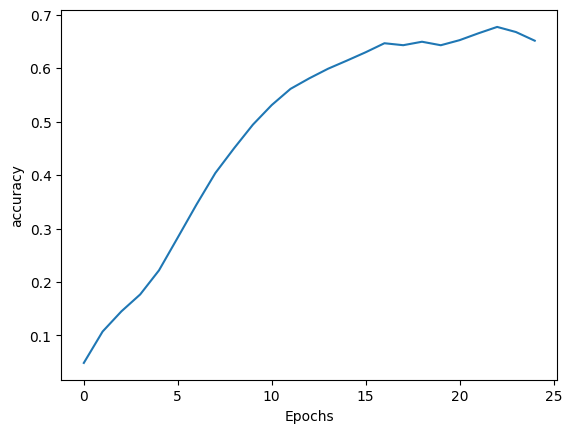

In [79]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()


# Visualize the accuracy
plot_graphs(history, "accuracy")

## Generating Text

Now you can let the model make its own songs or poetry! Because it is trained on a much larger corpus, the results below should contain less repetitions as before. The code below picks the next word based on the highest probability output.

In [115]:
# Define seed text
# seed_text = "help me obi-wan kinobi youre my only hope"
seed_text = 'elaine'

# Define total words to predict
next_words = 25

# Loop until desired length is reached
for _ in range(next_words):

    # Convert the seed text to a token sequence
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # Pad the sequence
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding="pre")

    # Feed to the model and get the probabilities for each index
    probabilities = model.predict(token_list)

    # Get the index with the highest probability
    predicted = np.argmax(probabilities, axis=-1)[0]

    # Ignore if index is 0 because that is just the padding.
    if predicted != 0:

        # Look up the word associated with the index.
        output_word = tokenizer.index_word[predicted]

        # Combine with the seed text
        seed_text += " " + output_word

# Print the result
print(seed_text)

1/1 [==============================] - 0s 56ms/step
elaine what are you doing here you got a nice guy a coffee grinder is where she's a little crumpled up to how to you do


Here again is the code that gets the top 3 predictions and picks one at random.

In [113]:
# Define seed text
# seed_text = "help me obi-wan kinobi youre my only hope"
seed_text = 'george'

# Define total words to predict
next_words = 20

# Loop until desired length is reached
for _ in range(next_words):

    # Convert the seed text to a token sequence
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # Pad the sequence
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding="pre")

    # Feed to the model and get the probabilities for each index
    probabilities = model.predict(token_list)

    # Pick a random number from [1,2,3]
    choice = np.random.choice([1, 2, 3])

    # Sort the probabilities in ascending order
    # and get the random choice from the end of the array
    predicted = np.argsort(probabilities)[0][-choice]

    # Ignore if index is 0 because that is just the padding.
    if predicted != 0:

        # Look up the word associated with the index.
        output_word = tokenizer.index_word[predicted]

        # Combine with the seed text
        seed_text += " " + output_word

# Print the result
print(seed_text)

1/1 [==============================] - 0s 56ms/step
george george here what did we say with this a 5 quitting even handed you much doesn't make that seem sure and


## Wrap Up

This lab shows the effect of having a larger dataset to train your text generation model. As expected, this will take a longer time to prepare and train but the output will less likely become repetitive or gibberish. Try to tweak the hyperparameters and see if you get better results. You can also find some other text datasets and use it to train the model here.  